# STUDENTS PERFORMANCE IN EXAMS AND PREDICTING SCORE IN MATH USING ML ALGOS

This dataset consists of 

In [1]:
from numpy import random
random.seed(12345)

In [72]:
from sklearn import metrics
from sklearn.metrics import r2_score
import sklearn

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'png'
sns.set()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
from scipy.stats import chi2_contingency

init_notebook_mode(connected=True)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance-in-exams/StudentsPerformance.csv


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
data=pd.read_csv("/kaggle/input/students-performance-in-exams/StudentsPerformance.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Dataset has zero null values with 8 columns and 1000 rows.

In [7]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [8]:
data.columns.unique()

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

**Renaming Columns**

In [9]:
columns1={'gender':'gender','race/ethnicity':'race','parental level of education':'parent_ed_level','lunch':'lunch_type','test preparation course':'test_prep','math score':'math','reading score':'reading','writing score':'writing'}
data.rename(columns=columns1,inplace=True)

In [10]:
data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading,writing
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


**Data Wrangling**

In [11]:
data['total']=data['math']+data['reading']+data['writing']

In [12]:
data['parent_ed_level'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

As we can see "some high school" and "high school" represent the same level of education, we can replace the former with a single value namely "high school".

In [13]:
data['parent_ed_level']=data['parent_ed_level'].replace(['some high school'],'high school')
data['parent_ed_level'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school'], dtype=object)

In [14]:
data['lunch_type']=data['lunch_type'].replace(['free/reduced'],'reduced')

In [15]:
data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading,writing,total
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           1000 non-null   object
 1   race             1000 non-null   object
 2   parent_ed_level  1000 non-null   object
 3   lunch_type       1000 non-null   object
 4   test_prep        1000 non-null   object
 5   math             1000 non-null   int64 
 6   reading          1000 non-null   int64 
 7   writing          1000 non-null   int64 
 8   total            1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


**VISUAL DATA ANALYSIS**

1) UNIVARIATE ANALYSIS

In this we look at one feature at a time. Finding out the distribution of that feature while ignoring other features is usually done here.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdca22820d0>,
      dtype=object)

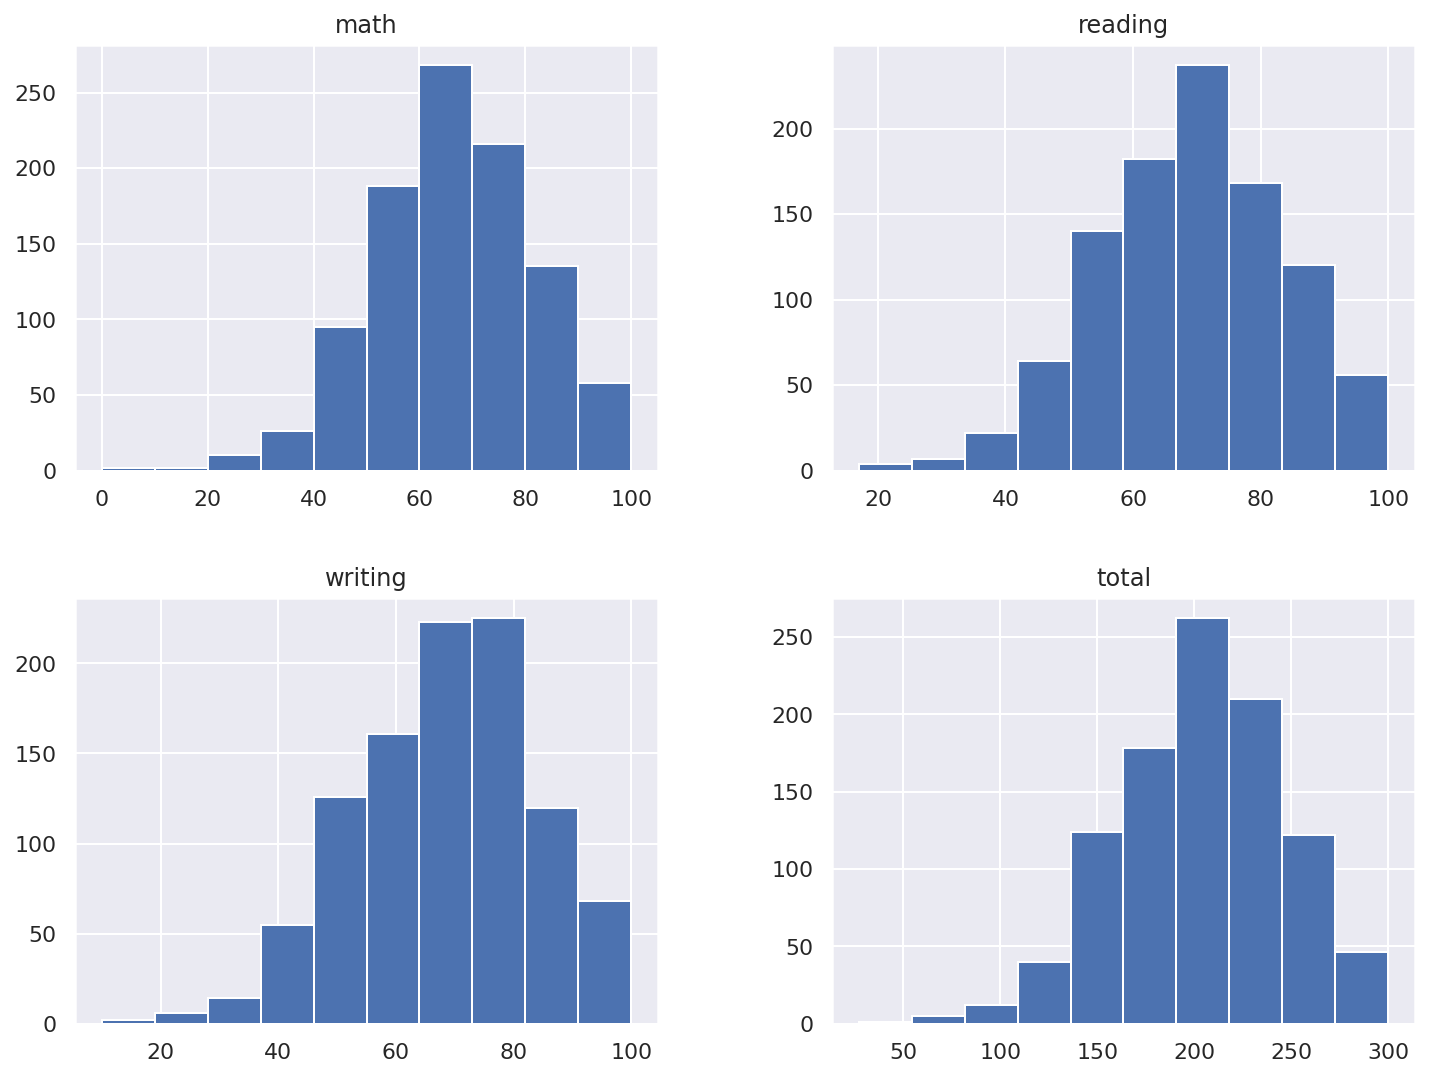

In [17]:
data[['math','reading','writing','total']].hist(figsize=(12,9))

Every distribution plotted above is Left-Skewed.

BOXPLOTS

In [18]:
#function to create a boxplot
def boxplot(column,dataf):
    plt.figure(figsize=(10,4))
    sns.boxplot(x=column,data=dataf)

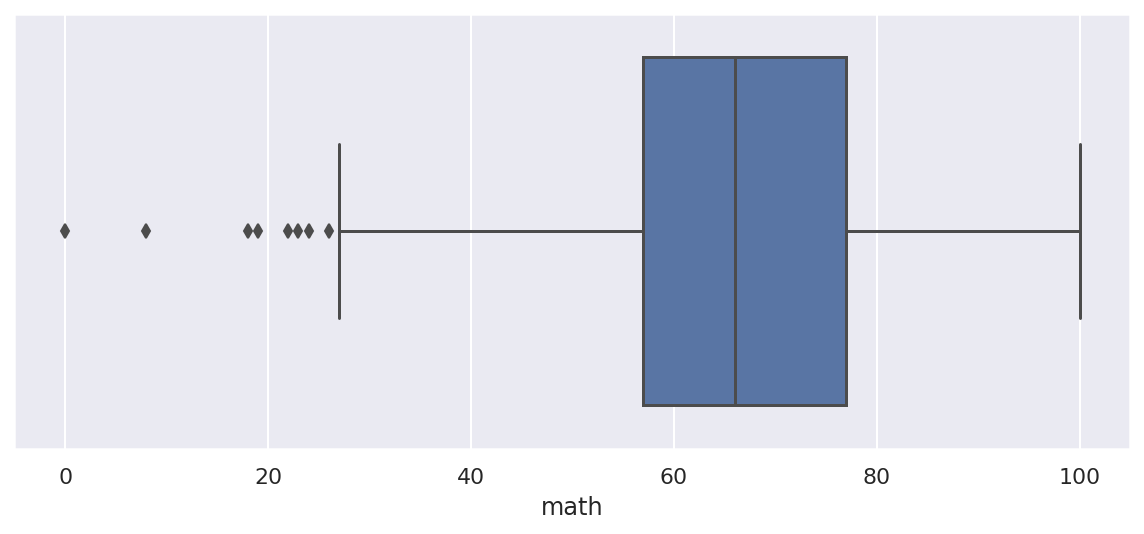

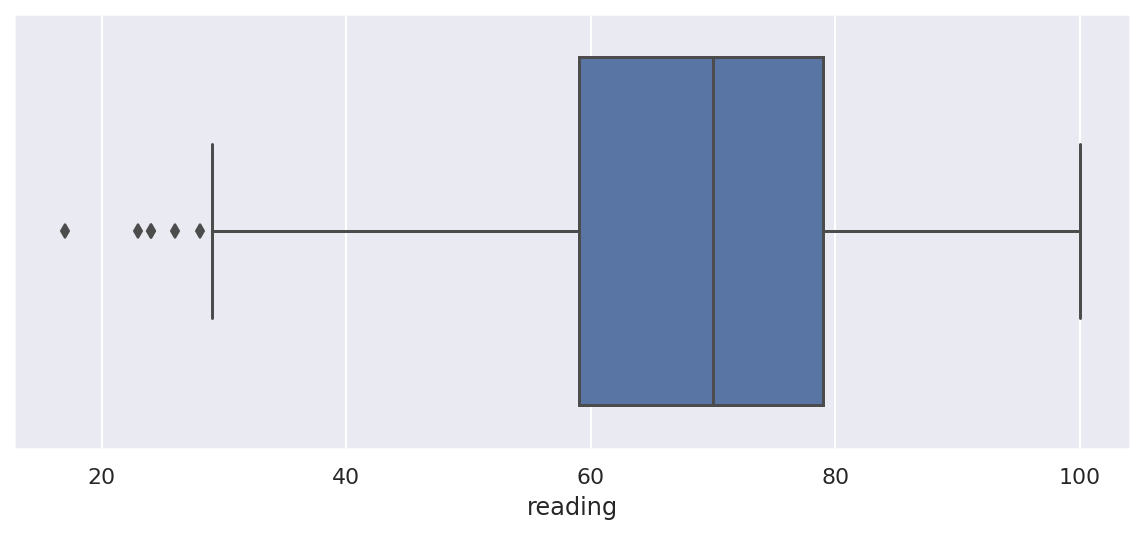

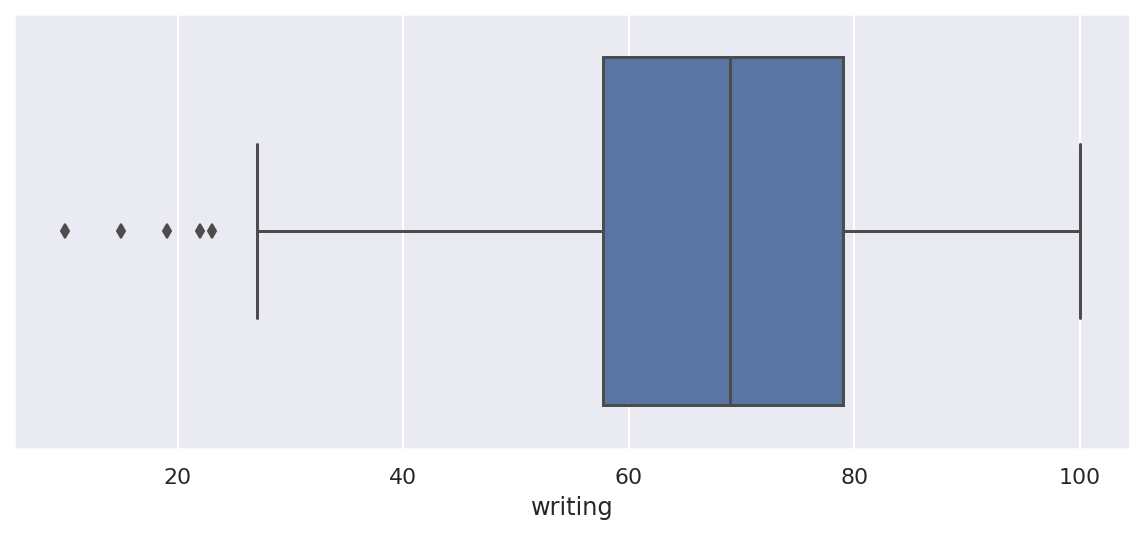

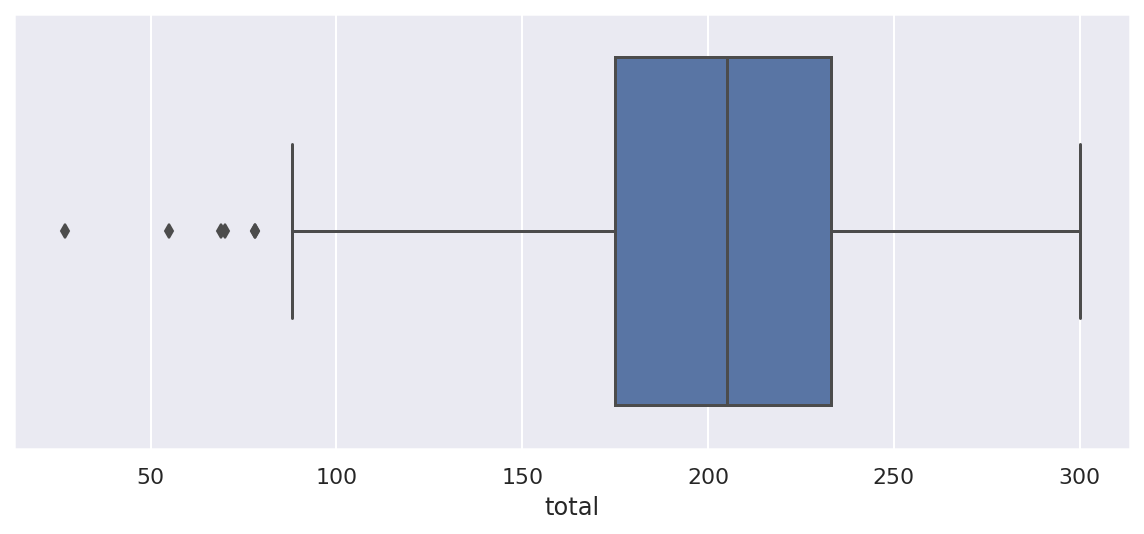

In [19]:
nums=['math','reading','writing','total']
for i in nums:
    boxplot(i,data)

#Interpreting boxplots

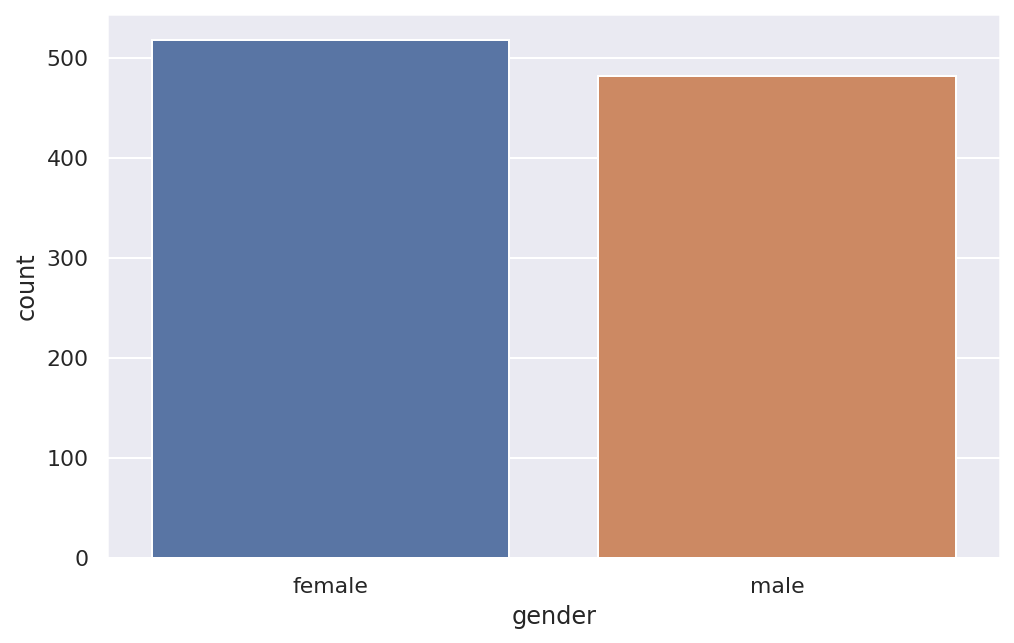

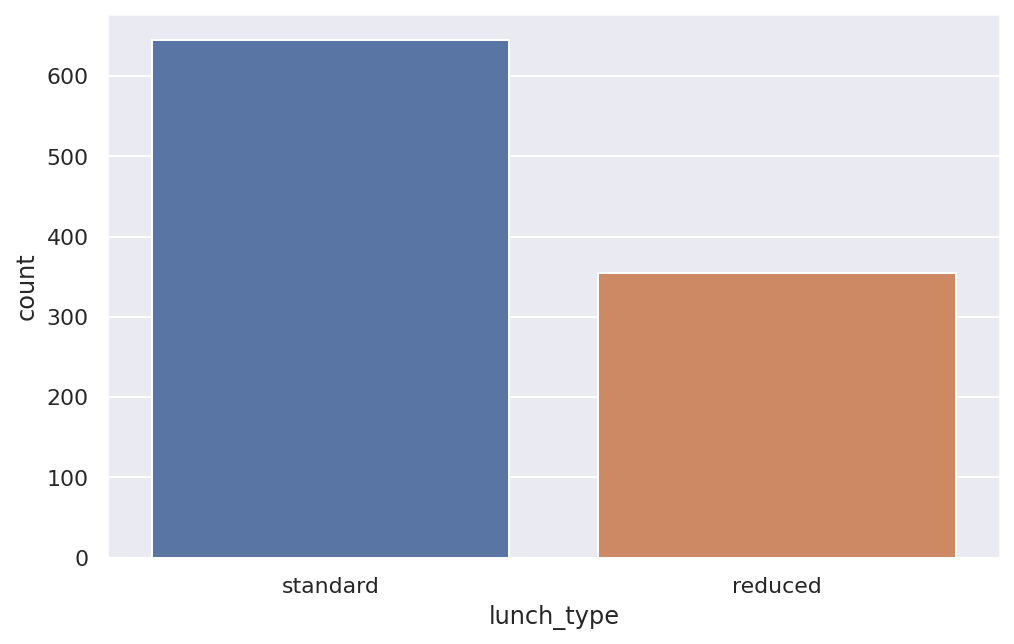

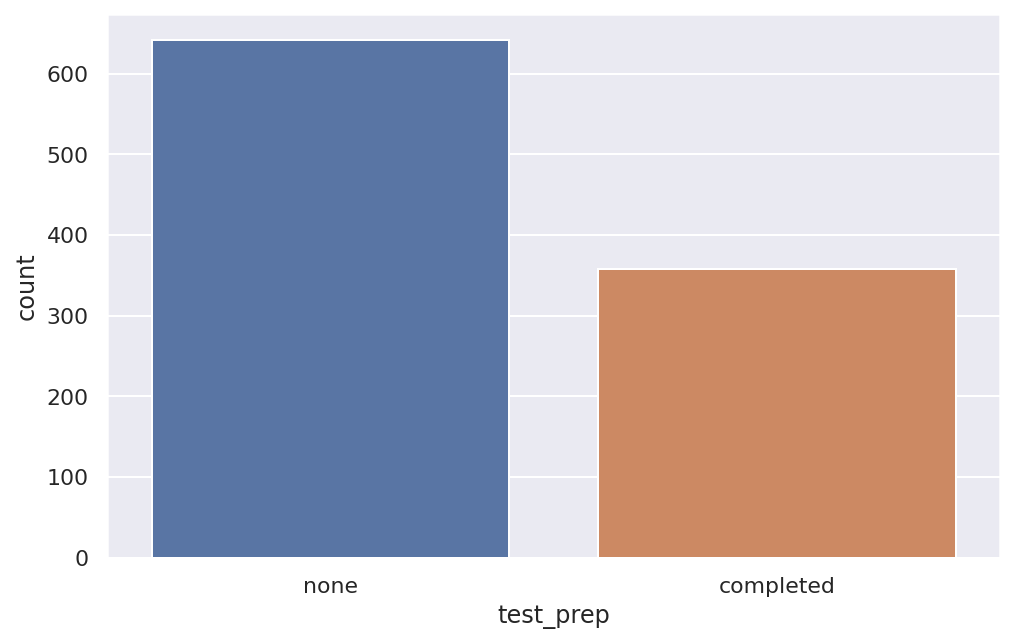

In [20]:
cat_list=['gender','lunch_type','test_prep']
for col in cat_list:
    plt.figure(figsize=(8,5))
    sns.countplot(x=col,data=data)

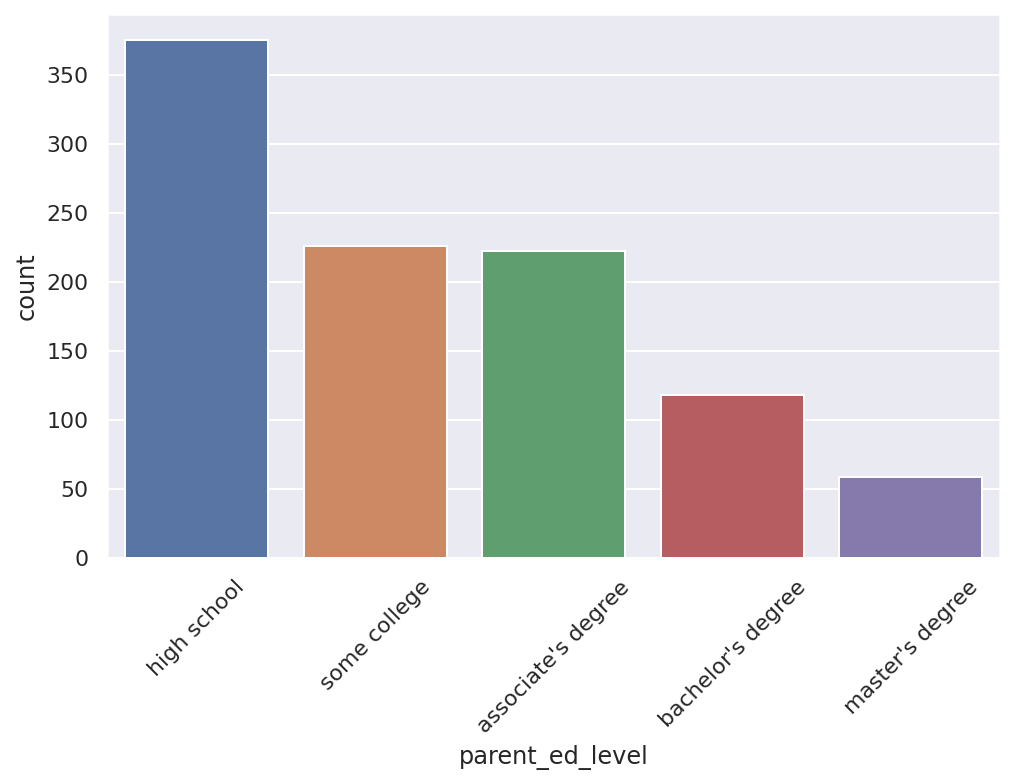

In [21]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.countplot(x='parent_ed_level',data=data,order=['high school','some college',"associate's degree","bachelor's degree","master's degree"])

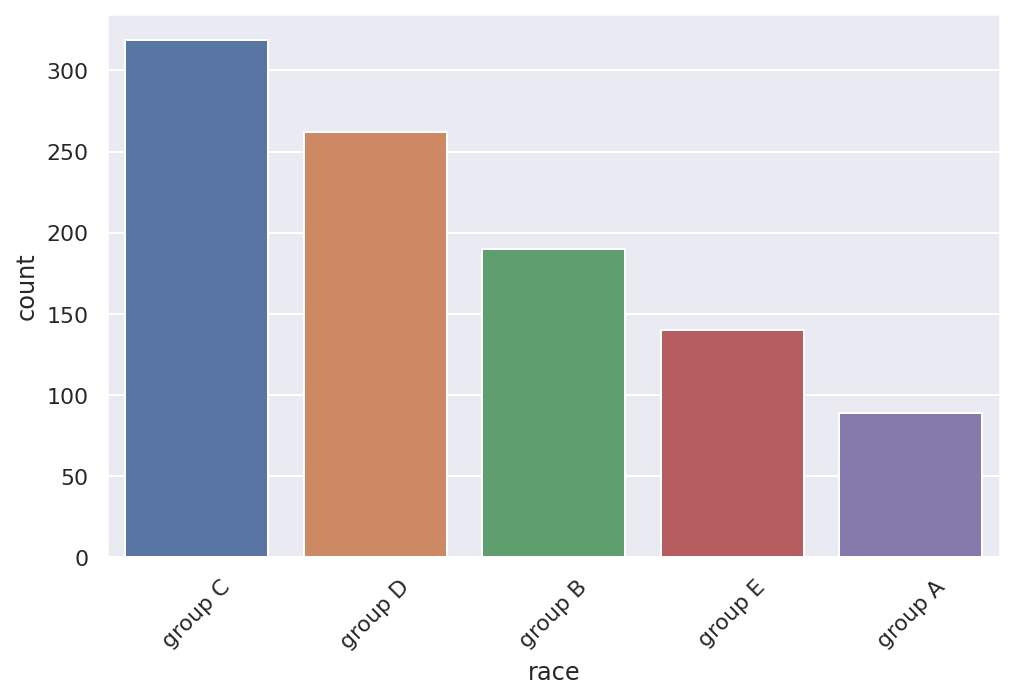

In [22]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.countplot(x='race',data=data,order=['group C','group D',"group B","group E","group A"])

2) MULTIVARIATE ANALYSIS

In [23]:
def hue(a,b):
    plt.figure(figsize=(8,5))
    if a=='parent_ed_level':
        plt.xticks(rotation=45)
    sns.countplot(x=a,data=data,hue=b)

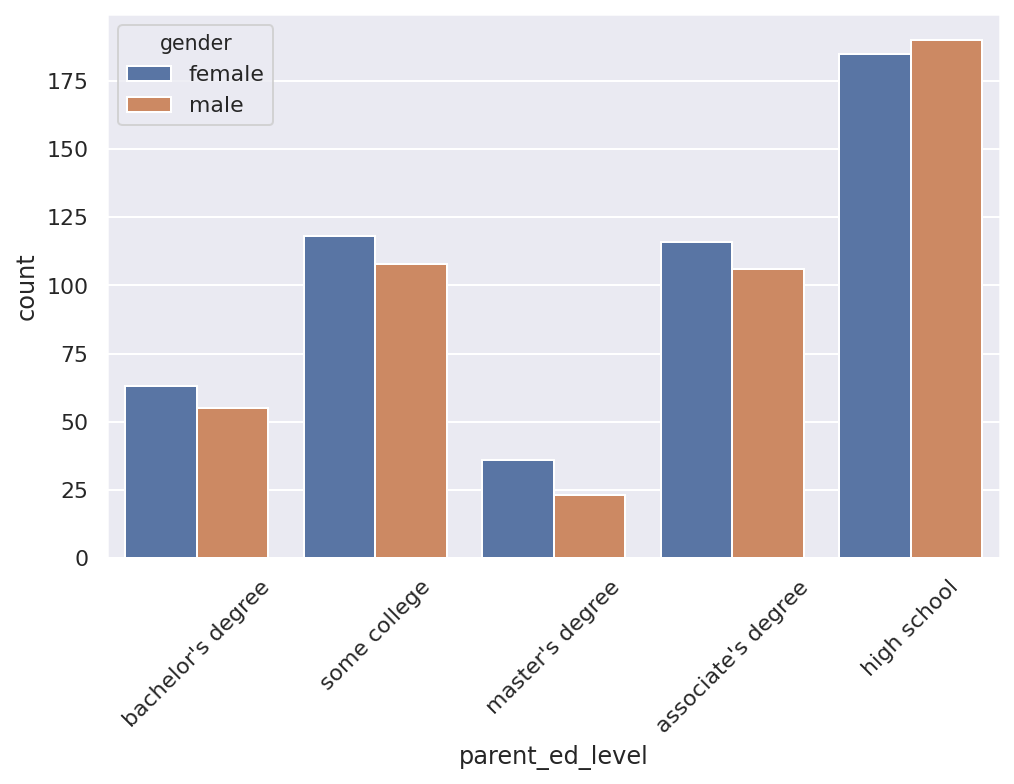

In [24]:
hue('parent_ed_level','gender')

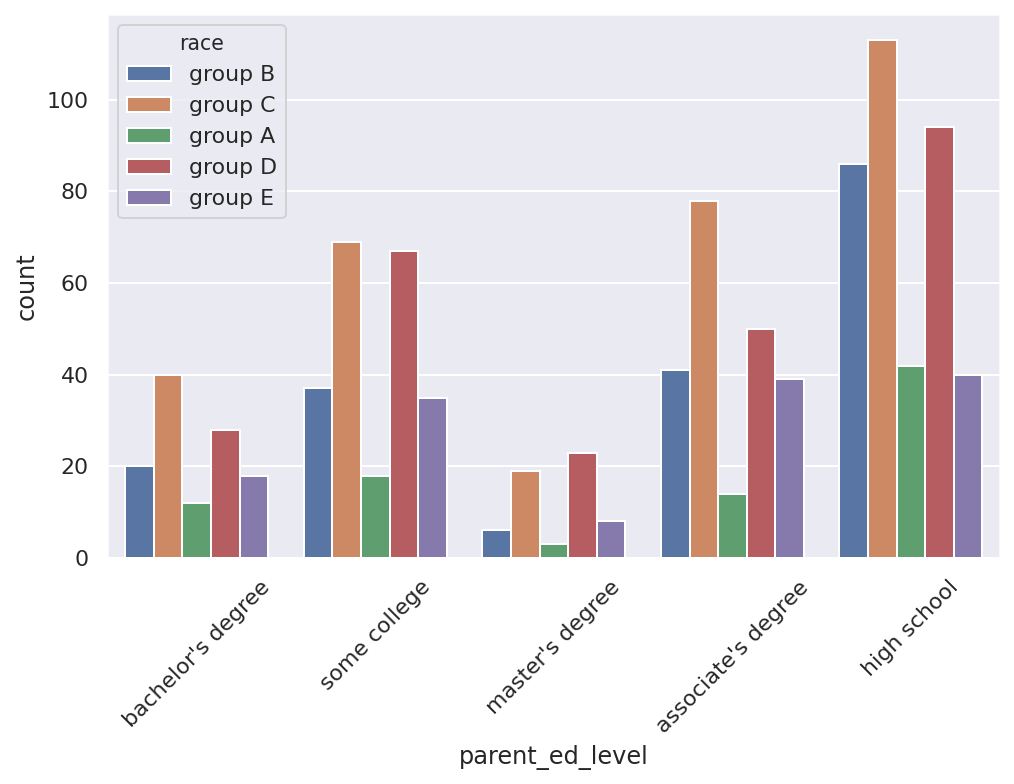

In [25]:
hue('parent_ed_level','race')

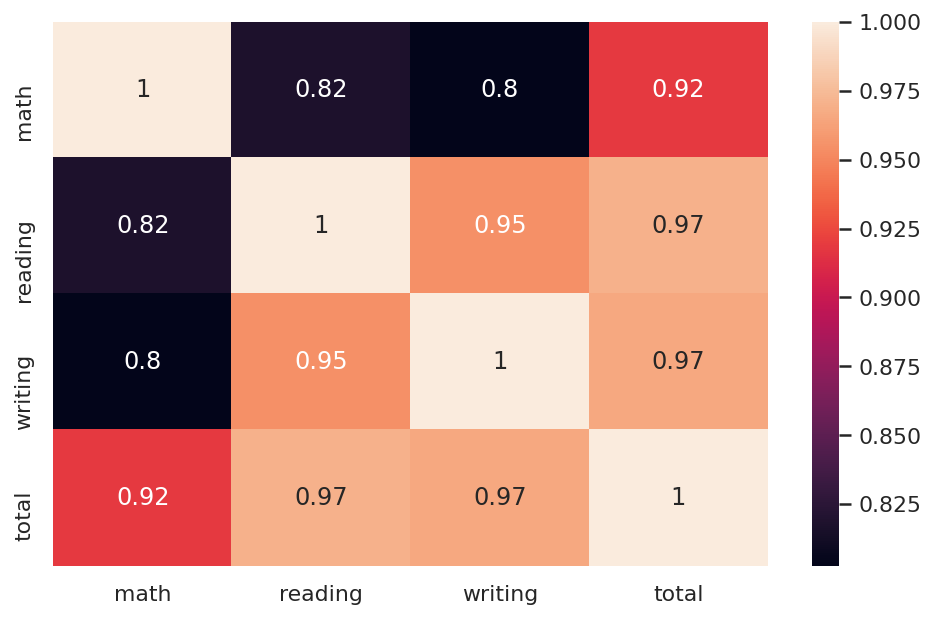

In [26]:
corr_matrix=data[nums].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True)

Correlation of "total" with "Reading" and "writing" is very high so we drop the total column.

In [27]:
data.drop(['total'],axis=1,inplace=True)

Now for feature engineering and feature selection to predict math score of students, I will create a copy of the original dataset and manipulate features there.

In [28]:
new_data=data.copy()

In [29]:
new_data.drop(['writing'],inplace=True,axis=1)

In [30]:
new_data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading
0,female,group B,bachelor's degree,standard,none,72,72
1,female,group C,some college,standard,completed,69,90
2,female,group B,master's degree,standard,none,90,95
3,male,group A,associate's degree,reduced,none,47,57
4,male,group C,some college,standard,none,76,78


<Figure size 864x360 with 0 Axes>

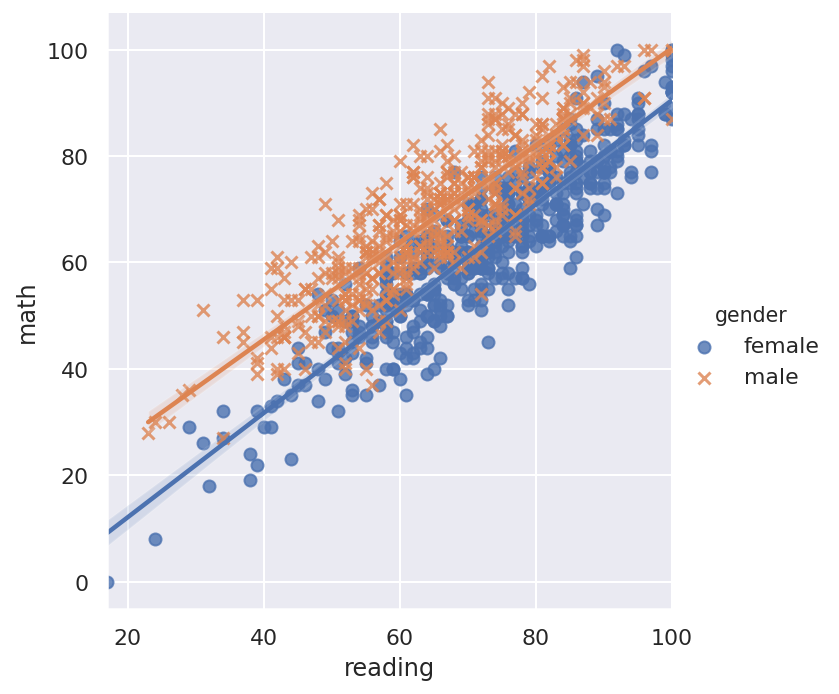

<Figure size 864x360 with 0 Axes>

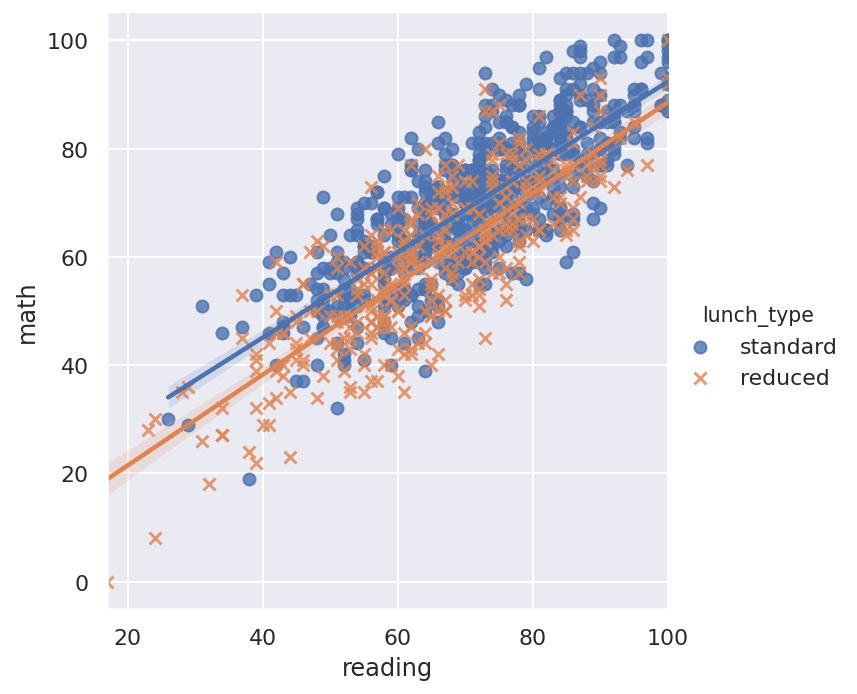

<Figure size 864x360 with 0 Axes>

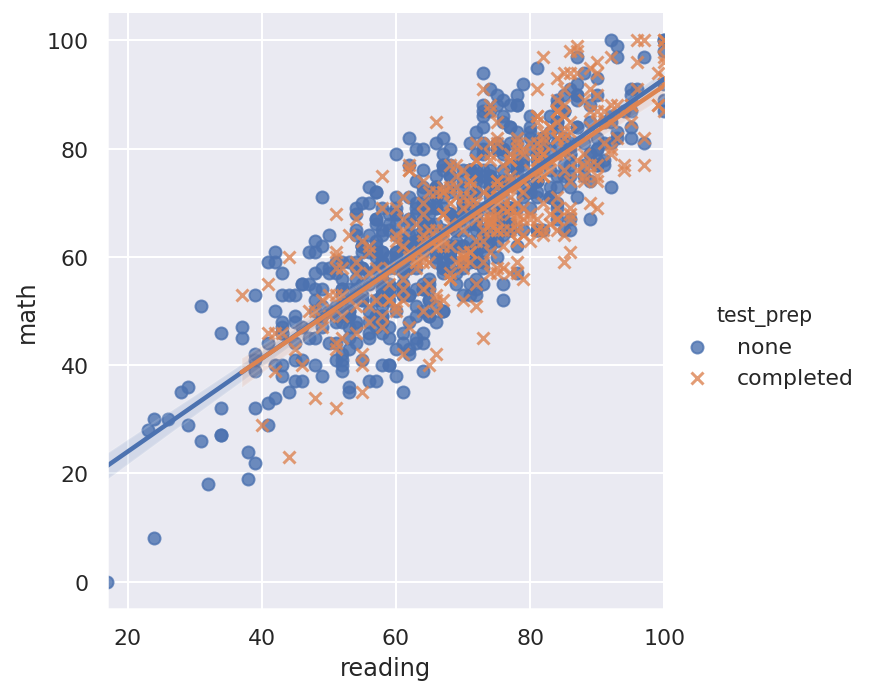

In [31]:
hue_list=['gender','lunch_type','test_prep']
for hue in hue_list:
    plt.figure(figsize=(12,5))
    sns.lmplot(x='reading',y='math',data=new_data,hue=hue,fit_reg=True,markers=['o','x'])

Out of the 3 scatterplots with different classification bases, gender and lunch_type seem the most effective on getting a good math score. So I will eliminate test_prep as one of the predicting features and go ahead with gender and lunch_type.

3) USING CHI-SQUARE TEST FOR FEATURE SELECTION

Here we consider two features at a time and test the null hypothesis which assumes that the 2 features are independent against the alternative hypothesis that those 2 features are dependent.

In [32]:
#creating a function to execute chisq test for independence
def chisq(col1,col2):
    #create a contingency table
    table=pd.crosstab(new_data[col1],new_data[col2])
    #get chi_Sq statistics,p-value,degrees of freedom and expected frequencies.
    stat, p, dof, expected = chi2_contingency(table)
    #set significance level
    alpha=0.05
    if p<=0.05:
        print('Features are associated')
    else:
        print('Features are not associated')

In [33]:
chisq('gender','lunch_type')
chisq('gender','parent_ed_level')
chisq('gender','race')
chisq('gender','test_prep')
chisq('lunch_type','test_prep')
chisq('lunch_type','parent_ed_level')
chisq('lunch_type','race')
chisq('parent_ed_level','race')
chisq('parent_ed_level','test_prep')
chisq('race','test_prep')

Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated


Since every pair of categorical features is independent we do not eliminate any of these for our feature selection process.

In [34]:
new_data.drop(['test_prep'],axis=1,inplace=True)

In [35]:
new_data.head()

,gender,race,parent_ed_level,lunch_type,math,reading
0,female,group B,bachelor's degree,standard,72,72
1,female,group C,some college,standard,69,90
2,female,group B,master's degree,standard,90,95
3,male,group A,associate's degree,reduced,47,57
4,male,group C,some college,standard,76,78


Encoding the categorical features

In [36]:
label=LabelEncoder()
cat_list=['gender','race','lunch_type','parent_ed_level']
for col in cat_list:
    new_data[col]=label.fit_transform(new_data[col])

In [37]:
new_data['race'].value_counts()

2    319
3    262
1    190
4    140
0     89
Name: race, dtype: int64

In [38]:
y=new_data['math']
new_data.drop(['math'],axis=1,inplace=True)

In [39]:
new_data['reading']=new_data['reading']/100.0

In [40]:
y=y/100.0

0      0.72
1      0.69
2      0.90
3      0.47
4      0.76
       ... 
995    0.88
996    0.62
997    0.59
998    0.68
999    0.77
Name: math, Length: 1000, dtype: float64


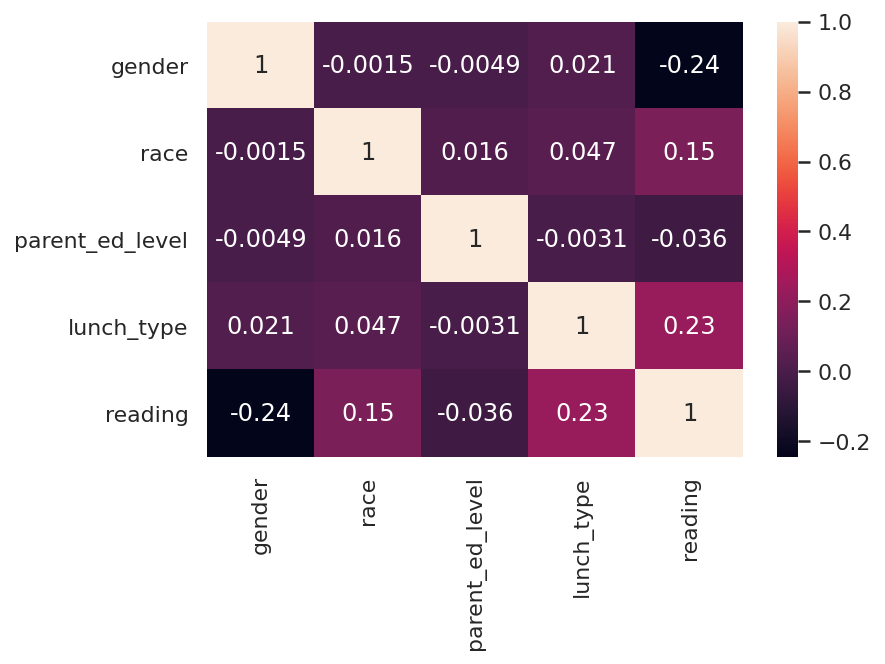

In [41]:
corr_matrix=new_data.corr()
sns.heatmap(corr_matrix,annot=True)

By correlation coefficient we can conclude that there is no high-level of correlation between any of the features.

4)Creating a Linear Regression Model based on selected features

In [42]:
X_train, X_holdout, y_train, y_holdout = train_test_split(new_data.values, y, test_size=0.2,
random_state=17)
reg=LinearRegression()
reg.fit(X_train,y_train)
pred=reg.predict(X_holdout)

In [54]:
#creating a function that prints all relevant regression metrics when called
def reg_metrics(actual,predicted):
    mae=metrics.mean_absolute_error(actual,predicted)
    mse=metrics.mean_squared_error(actual,predicted)
    rmse=np.sqrt(metrics.mean_squared_error(actual,predicted))
    r2=r2_score(actual,predicted)
    print("MAE:",mae)
    print("MSE:",mse)
    print("RMSE:",rmse)
    print("R2:",r2)

In [62]:
#creating a function to plot a histogram of the residual values.
def residual_plot(actual,predicted):
    plt.figure(figsize=(10,6))
    plt.xlabel('Residual error value')
    plt.title('Residual Plot',size=13)
    plt.hist(actual-predicted)
#plotting the residual error plot

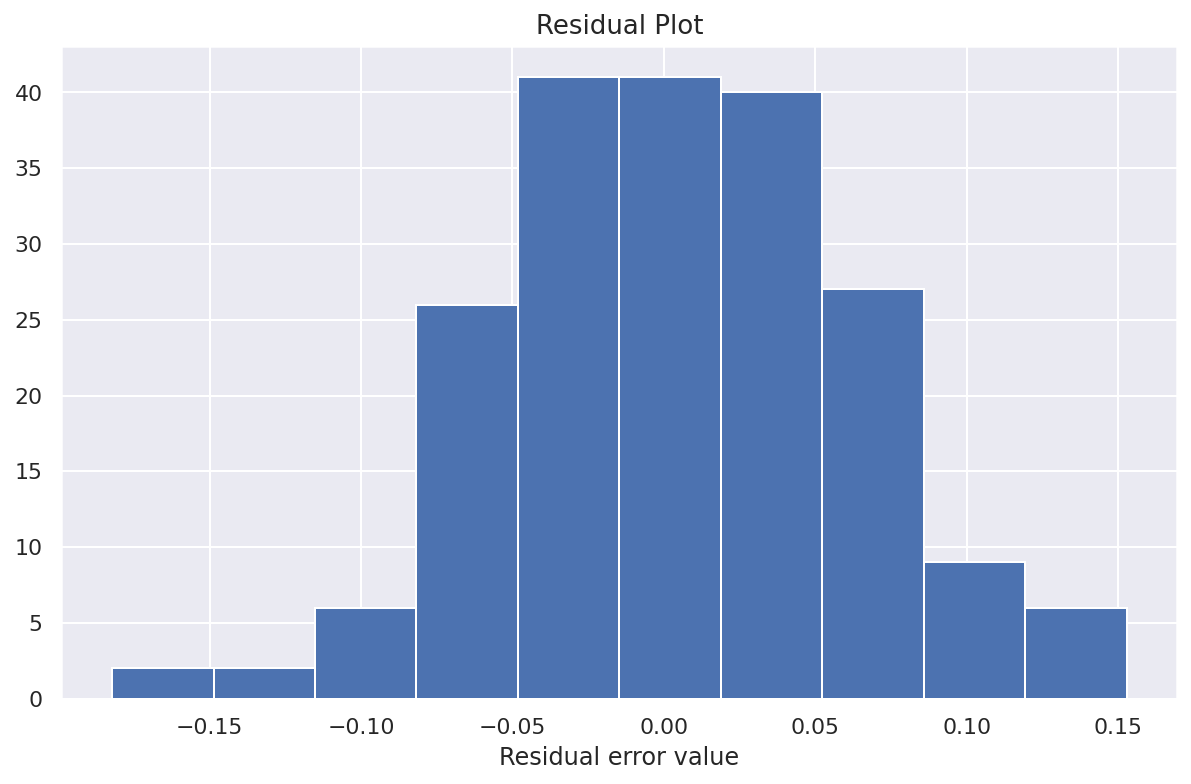

In [63]:
residual_plot(y_holdout,pred)

In [64]:
reg_metrics(y_holdout,pred)
#printing out evaluation metrics of the model

MAE: 0.04805936421122432
MSE: 0.0035795212102547125
RMSE: 0.059829100028787933
R2: 0.8425251603992516


Defining the metrics obtained above:

1) MAE is just the Mean Absolute Error, ie the mean of residual errors mathematically given by sum(abs(Y(actual)-Y(pred)))/no.of predictions

2) MSE is the Mean Square Error, ie the square of the MAE.

3) RMSE is the square root of MSE.

4) R2 score returns a value that tells you how much of the variation in the target variable has been captured by the features used to predict said target variable.

In [73]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

#Optimising The Model